## 1. 라이브러리 호출

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import pickle
import warnings
warnings.filterwarnings('ignore')

## 2. 데이터 불러오기

##### fa 객체와 회귀계수 데이터 불러오기
- pickle 사용

In [ ]:
with open("data/coef.pickle",'rb') as f:
    factor_coefficients_for_backtest = pickle.load(f)
    fa = pickle.load(f)

##### 2015~2020 년 데이터 불러온 후 스케일러 적합

In [ ]:
score = pd.read_excel("data/factor_loadings.xlsx",index_col=0)
cols = score.index
factor_list = score.columns
df_2015_2020 = pd.read_excel('data/ts_rtn_2015_2020.xlsx')
scaler = StandardScaler()
scaler.fit(df_2015_2020[cols])
filtered_data = df_2015_2020[cols]

StandardScaler()

##### 백테스팅 데이터 불러오기

In [ ]:
df = pd.read_excel('data/ts_rtn_2021_2024.xlsx', dtype = {'주식코드':str})

##### 백테스팅 기간 정의, 포트폴리오 수익률, 연도 변수 생성

In [81]:
test_start_year = 2021
test_end_year = 2024 # 테스트 기간 끝 연도 (학습된 모델을 이 기간에 적용)

num_top_firms = 10 # 매년 매수할 상위 기업 수

portfolio_returns_annual = [] # 각 연도별 포트폴리오 수익률 저장
portfolio_years = [] # 수익률이 계산된 연도 저장
return_col_name = '수익률'

##### 데이터 구조 맞추기

In [ ]:
df = df[cols]
df1 = pd.merge(df.iloc[:, :3], df, left_index=True, right_index=True, how = 'outer')
backtest_df = pd.merge(df1, df.iloc[:, -1:], left_index=True, right_index=True, how = 'outer')

## 3. 백테스팅
- Factor Score 계산
- Z-score 계산 및 방향 조정
- 최종 점수 계산 및 포트폴리오 구성
- 포트폴리오 수익률 계산

In [ ]:
for current_year in range(test_start_year, test_end_year + 1):
    print(f"\n--- 백테스팅 연도: {current_year} ---")

    # 현재 연도(테스트 기간)의 원본 재무 변수 데이터 추출
    current_year_data_raw = backtest_df[backtest_df['연도'] == current_year].copy()

    # 재무 변수와 수익률 분리
    x_current_year_raw = current_year_data_raw.iloc[:, 3:-1]
    y_current_year = current_year_data_raw.iloc[:, -1:]

    # 1. 재무 변수 전처리 (표준화)
    # 학습 기간에 fit 된 `scaler_financial` 객체를 사용하여 현재 연도 데이터를 `transform`만 합니다.
    # 이는 학습 기간과 동일한 기준으로 데이터를 표준화하기 위함입니다.

    # 학습된 변수 필터링 목록 (x_train_filtered_final의 컬럼들)과 현재 데이터의 공통 컬럼만 선택
    # Factor 모델은 학습된 컬럼 순서와 개수를 기대하므로 맞춰줍니다.
    common_cols_for_factor = list(set(filtered_data.columns) & set(x_current_year_raw.columns))

    if not common_cols_for_factor:
        print(f"  {current_year}년도 데이터에 학습 기간에서 사용된 재무 변수가 없습니다. 다음 연도로 이동.")
        portfolio_returns_annual.append(0)
        portfolio_years.append(current_year)
        continue

    # 학습된 필터링된 컬럼의 순서에 맞춰 현재 데이터를 재정렬
    x_current_year_aligned = x_current_year_raw[filtered_data.columns].copy()
    x_current_year_scaled = pd.DataFrame(scaler.transform(x_current_year_raw),
                                         columns=x_current_year_raw.columns,
                                         index=x_current_year_raw.index)


    # 2. 고정된 Factor 모델 (fa_fixed_model)을 사용하여 Factor Score 계산
    # 학습 기간에서 fit된 FactorAnalyzer 객체를 사용하여 현재 연도 데이터를 transform 합니다.
    # 이렇게 하면 현재 연도의 재무 변수들이 학습 기간에 정의된 Factor 구조에 따라 Factor Score로 변환됩니다.
    current_year_factor_scores = pd.DataFrame(fa.transform(x_current_year_scaled),
                                              columns=[f"factor_{i+1}" for i in range(optim)],
                                              index=x_current_year_scaled.index)

    # 3. Z-score 계산 (현재 연도 Factor Score 바탕)
    # Factor Score 자체의 Z-score는 매년 해당 연도의 기업들 사이에서의 상대적 순위를 반영해야 하므로, 매년 새로 계산합니다.
    # 고정된 유의한 Factor들만 선택합니다.
    factors_for_zscore_names = [f for f in factor_list if f in current_year_factor_scores.columns]

    if not factors_for_zscore_names:
        print(f"  {current_year}년도 데이터에 백테스팅에 사용할 유의한 Factor 컬럼이 없습니다. 다음 연도로 이동.")
        portfolio_returns_annual.append(0)
        portfolio_years.append(current_year)
        continue

    factor_scores_for_zscore = current_year_factor_scores[factors_for_zscore_names]

    scaler_z_period = StandardScaler()
    z_scores_period = scaler_z_period.fit_transform(factor_scores_for_zscore)
    z_scores_df_period = pd.DataFrame(z_scores_period,
                                       columns=[f"{col}_zscore" for col in factors_for_zscore_names],
                                       index=factor_scores_for_zscore.index)

    # 4. Z-score 조정 (고정된 회귀 계수 부호에 따라)
    # 학습 기간에 고정된 RLM 회귀 계수의 부호를 사용하여 Z-score의 방향성을 조정합니다.
    adjusted_z_scores_period = z_scores_df_period.copy()
    for factor in factors_for_zscore_names:
        # 고정된 RLM 계수가 음수이면 Z-score 순위를 반전 (높은 Z-score가 좋은 기업이 되도록)
        if factor_coefficients_for_backtest[factor] < 0:
            adjusted_z_scores_period[f"{factor}_zscore"] *= -1

    # 5. 기업별 최종 랭크 점수 계산 (조정된 Z-score 합산)
    # 조정된 Z-score들을 합산하여 각 기업의 최종 랭크 점수를 계산합니다.
    firm_rank_score_period = adjusted_z_scores_period.sum(axis=1)
    firm_rank_score_period = firm_rank_score_period.sort_values(ascending=False)

    # 6. 포트폴리오 구성: 상위 N개 기업 선정
    # 랭크 점수가 가장 높은 상위 'num_top_firms' 개 기업을 선정합니다.
    top_firms_indices = firm_rank_score_period.head(num_top_firms).index

    # 선정된 기업들의 '주식코드'와 '수익률'을 가져옵니다.
    portfolio_firms_info = current_year_data_raw.loc[top_firms_indices]
    top_firms_codes = portfolio_firms_info['주식코드'].tolist()

    if not top_firms_codes:
        print(f"  {current_year}년도에 포트폴리오에 편입할 기업이 없습니다. 다음 연도로 이동.")
        portfolio_returns_annual.append(0)
        portfolio_years.append(current_year)
        continue

    # 7. 포트폴리오 수익률 계산 (선정된 기업들의 현재 연도 '수익률' 평균)
    # 선정된 기업들의 해당 연도 수익률을 평균하여 포트폴리오의 연간 수익률로 간주합니다 (동일 가중 포트폴리오).
    portfolio_avg_return = portfolio_firms_info[return_col_name].mean()
    portfolio_returns_annual.append(portfolio_avg_return)
    portfolio_years.append(current_year)
    print(f"  {current_year}년도 포트폴리오 평균 수익률: {portfolio_avg_return:.2%}")


--- 백테스팅 연도: 2021 ---
  2021년도 포트폴리오 평균 수익률: -13.56%

--- 백테스팅 연도: 2022 ---
  2022년도 포트폴리오 평균 수익률: -14.52%

--- 백테스팅 연도: 2023 ---
  2023년도 포트폴리오 평균 수익률: 69.65%

--- 백테스팅 연도: 2024 ---
  2024년도 포트폴리오 평균 수익률: -5.61%


##### 백테스트 결과 분석 및 성과 지표 출력
- 백테스트 결과 확인
- 연간 및 누적 수익률 출력
- 포트폴리오 누적 수익률 시각화
- 성과 지표 계산 (CAGR, Annualized Volatility, Sharpe Ratio)


--- 최종 백테스팅 연간 수익률 ---
2021   -0.135608
2022   -0.145217
2023    0.696487
2024   -0.056149
dtype: float64

--- 누적 수익률 ---
2021    0.864392
2022    0.738867
2023    1.253479
2024    1.183097
dtype: float64


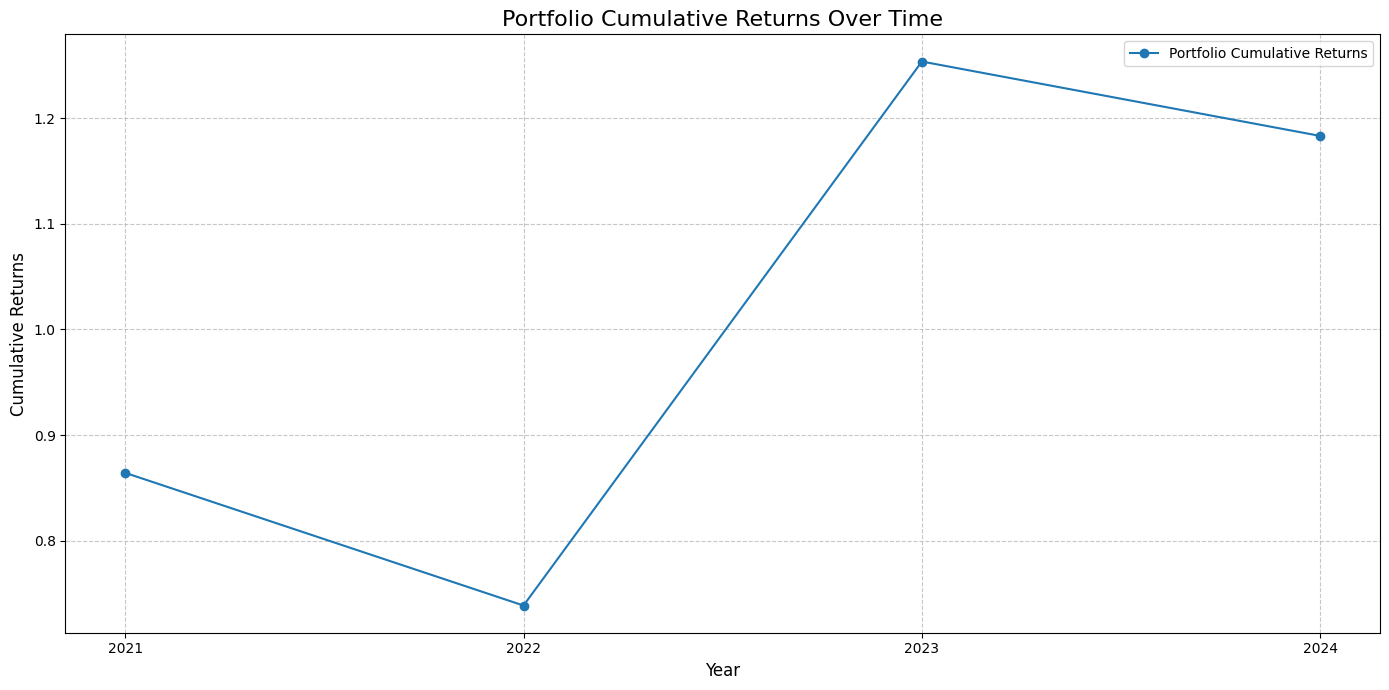


--- 백테스팅 성과 요약 ---
총 백테스팅 기간: 2021년 - 2024년 (4년)
연평균 수익률 (CAGR): 4.29%
연간 변동성 (Standard Deviation): 40.64%
샤프 비율 (무위험 이자율 2.00%): 0.06


In [69]:
if not portfolio_returns_annual:
    print("\n백테스팅을 수행할 충분한 데이터가 없거나 모든 연도에서 포트폴리오 구성에 실패했습니다.")
else:
    portfolio_returns_series = pd.Series(portfolio_returns_annual, index=portfolio_years)

    print("\n--- 최종 백테스팅 연간 수익률 ---")
    print(portfolio_returns_series)

    # 누적 수익률 계산
    cumulative_returns = (1 + portfolio_returns_series).cumprod()
    print("\n--- 누적 수익률 ---")
    print(cumulative_returns)

    # 시각화: 포트폴리오 누적 수익률 그래프
    plt.figure(figsize=(14, 7))
    plt.plot(cumulative_returns.index, cumulative_returns.values, marker='o', linestyle='-', label='Portfolio Cumulative Returns')
    plt.title('Portfolio Cumulative Returns Over Time', fontsize=16)
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('Cumulative Returns', fontsize=12)
    plt.xticks(cumulative_returns.index)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=10)
    plt.tight_layout()
    plt.show()

    # 추가적인 성과 지표 계산
    total_years = len(portfolio_returns_series)
    if total_years > 0:
        # 연평균 수익률 (CAGR: Compound Annual Growth Rate)
        annualized_return = (cumulative_returns.iloc[-1])**(1/total_years) - 1
        # 연간 변동성 (표준편차)
        annualized_volatility = portfolio_returns_series.std()

        # 무위험 이자율 가정 (예: 2%) - 실제 분석에서는 시장 상황에 맞는 무위험 이자율을 사용해야 합니다.
        risk_free_rate = 0.02
        sharpe_ratio = np.nan
        if annualized_volatility > 0:
            sharpe_ratio = (annualized_return - risk_free_rate) / annualized_volatility

        print(f"\n--- 백테스팅 성과 요약 ---")
        print(f"총 백테스팅 기간: {portfolio_returns_series.index.min()}년 - {portfolio_returns_series.index.max()}년 ({total_years}년)")
        print(f"연평균 수익률 (CAGR): {annualized_return:.2%}")
        print(f"연간 변동성 (Standard Deviation): {annualized_volatility:.2%}")
        print(f"샤프 비율 (무위험 이자율 {risk_free_rate:.2%}): {sharpe_ratio:.2f}")
    else:
        print("\n백테스팅 결과가 없어 성과 지표를 계산할 수 없습니다.")